In [1]:
!nvidia-smi

Wed Jun  4 05:53:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !mkdir {HOME}/datasets
# %cd {HOME}/datasets
!mkdir -p $HOME/datasets
%cd $HOME/datasets

[Errno 2] No such file or directory: '$HOME/datasets'
/content


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="s3Ht70Tgjv1bCzRzVNwx")
project = rf.workspace("beanalyze").project("beanalyze-object-detection")
version = project.version(8)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


In [4]:
%pip install - U ultralytics supervision "ultralytics<=8.3.40"
import ultralytics
ultralytics.checks()

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/112.6 GB disk)


In [5]:
pip install -U ultralytics

In [6]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

In [9]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=20 imgsz=416 plots=True patience=3 device=0

[Errno 2] No such file or directory: '{HOME}'
/content
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Beanalyze-Object-Detection-8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask

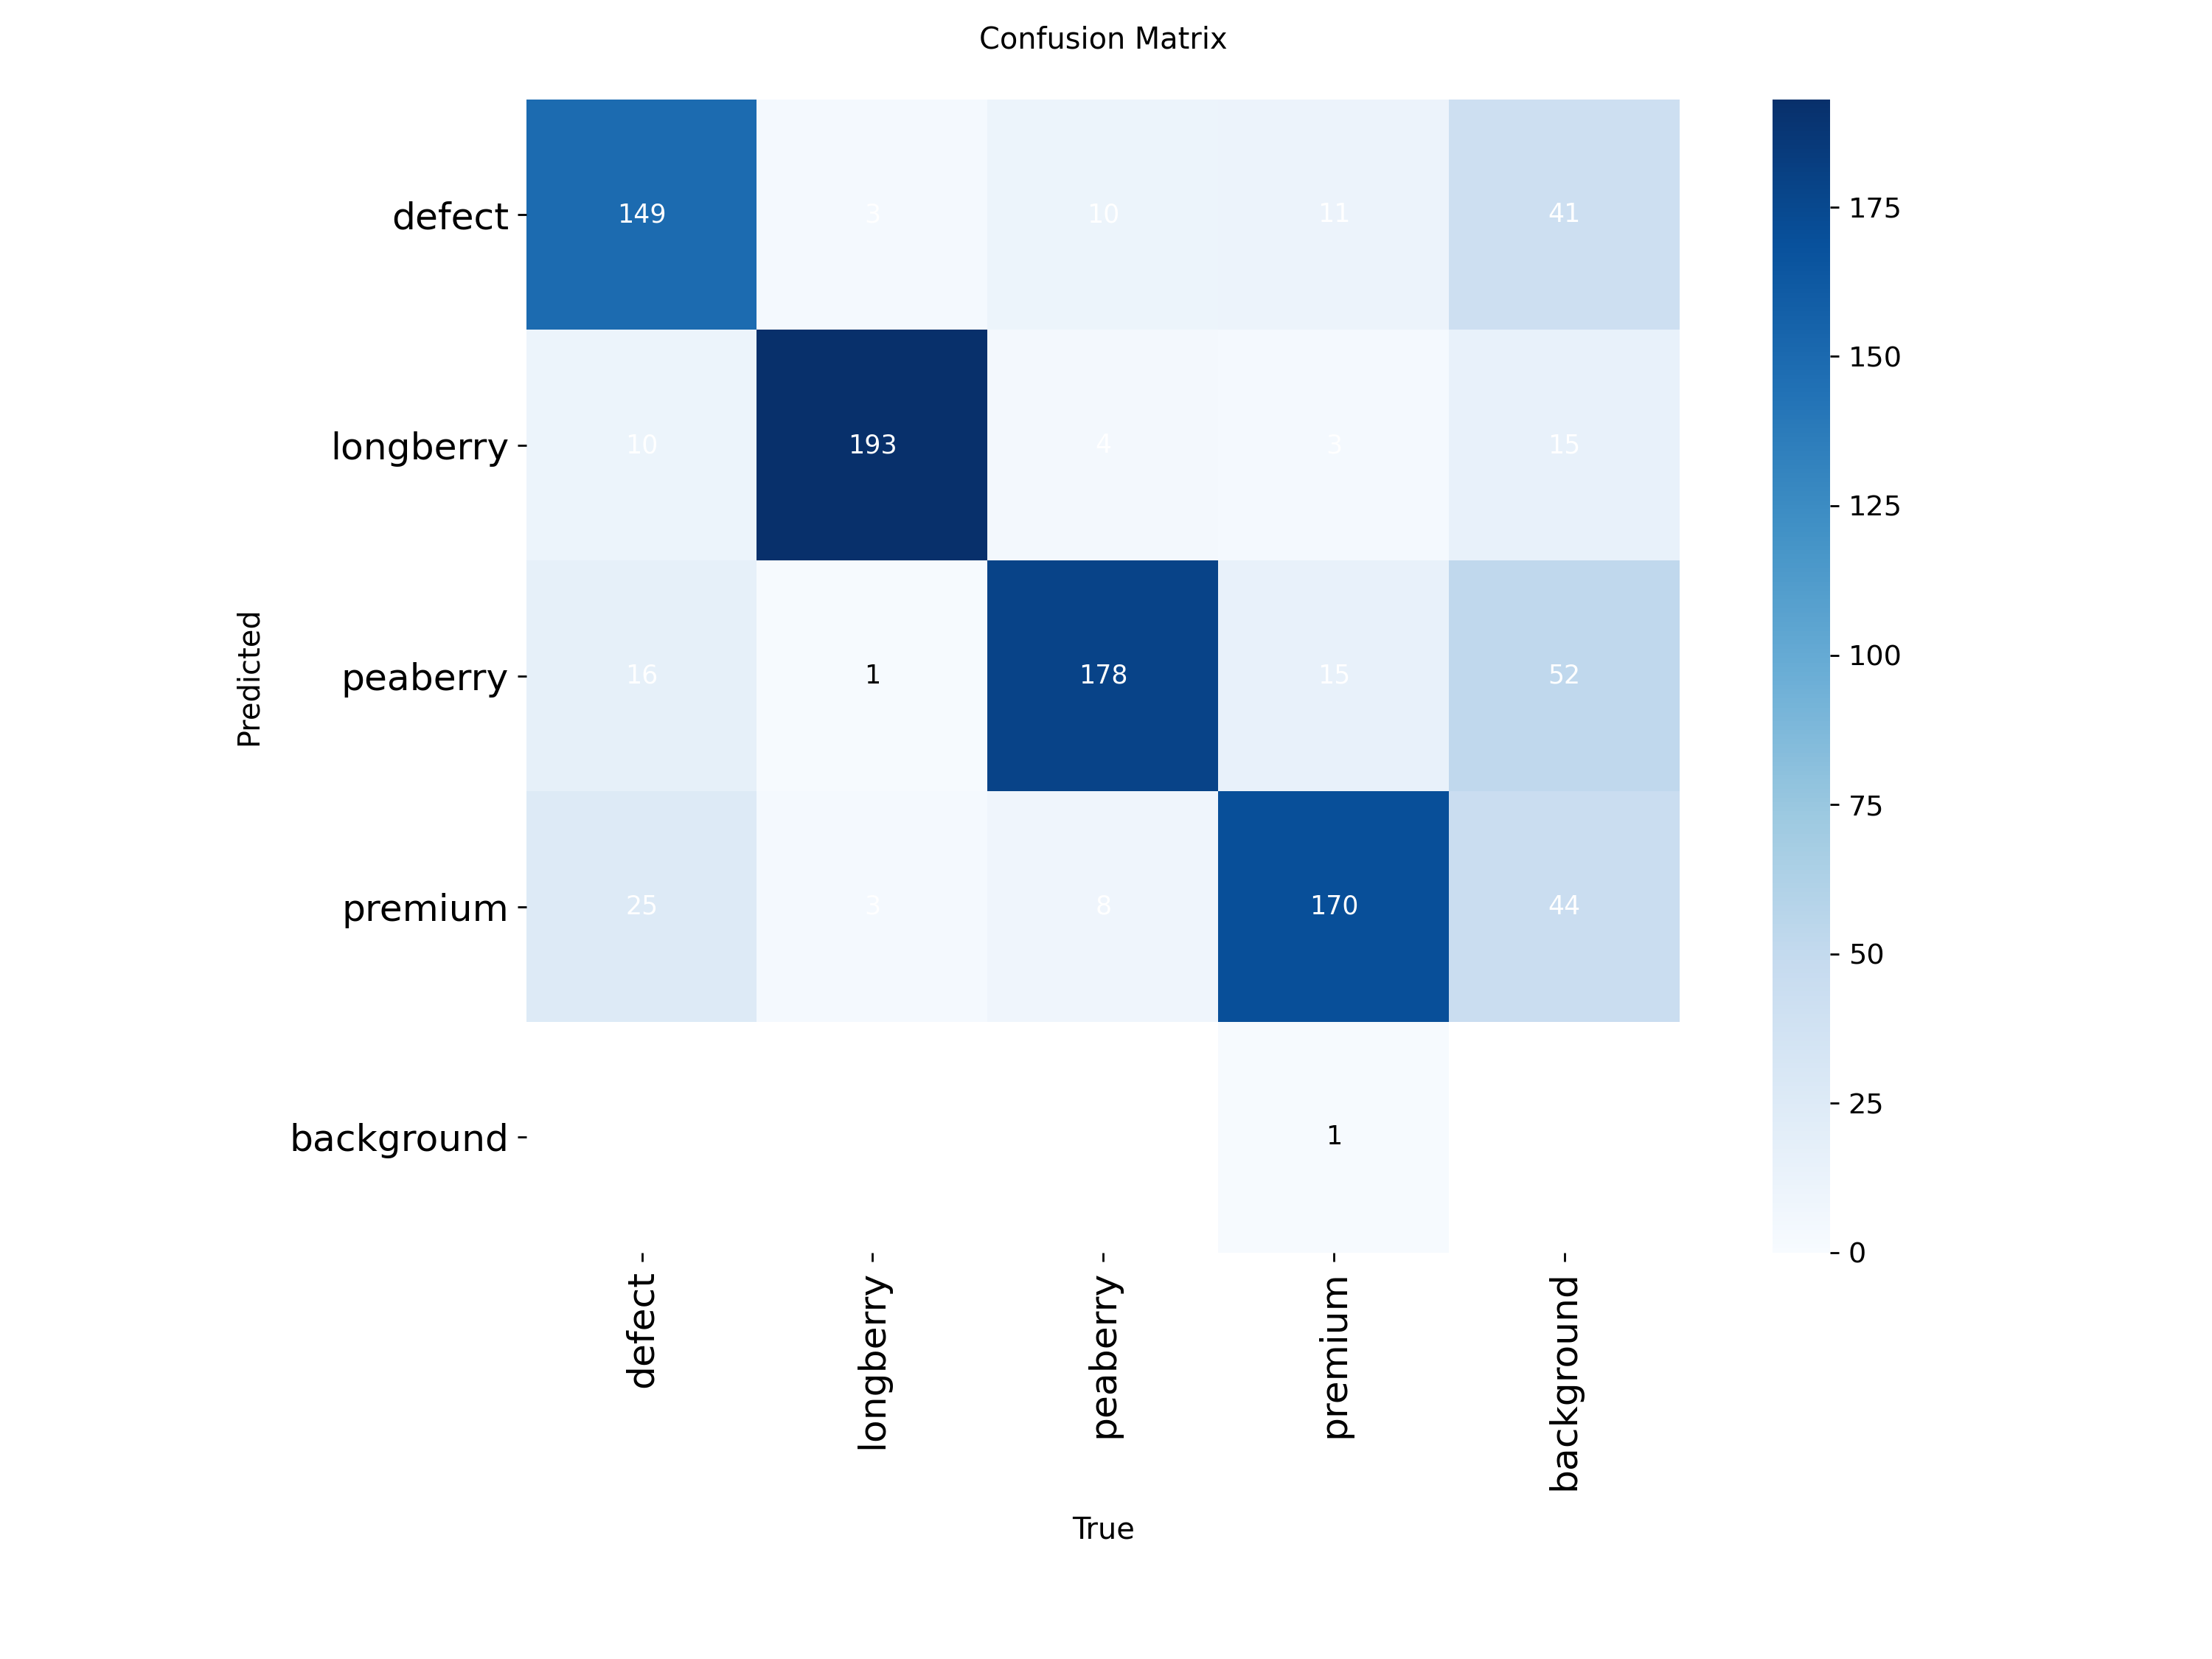

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/confusion_matrix.png', width=800)


In [11]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")

In [12]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 261.6±100.0 MB/s, size: 5.3 KB)


val: Scanning /content/Beanalyze-Object-Detection-8/valid/labels.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


                   all        800        800      0.883       0.88      0.945      0.854
                defect        200        200      0.928      0.772      0.924      0.853
             longberry        200        200      0.932      0.964      0.985      0.821
              peaberry        200        200      0.857       0.93      0.951       0.86
               premium        200        200      0.814      0.852       0.92      0.879
Speed: 0.4ms preprocess, 10.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


array([    0.85317,     0.82147,     0.86031,     0.87949])

In [13]:
# Export the model
model.export(format="onnx")

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 8, 3549) (38.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 14.2s, saved as '/content/runs/detect/train/weights/best.onnx' (76.6 MB)

Export complete (15.5s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=4

'/content/runs/detect/train/weights/best.onnx'

In [14]:
# Export the model to TFLite format
# model.export(format="tflite")
!yolo export model="/content/runs/detect/train/weights/best.pt" format=tflite

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 8, 3549) (38.6 MB)
E0000 00:00:1749019928.293486   17362 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749019928.381823   17362 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 7.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedMode

In [15]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"/content/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/beanalyze/beanalyze-object-detection/8
Share your model with the world at: https://universe.roboflow.com/beanalyze/beanalyze-object-detection/model/8


In [20]:
from google.colab import files
!zip -r /content/best_saved_model.zip /content/runs/detect/train/weights/
files.download('/content/best_saved_model.zip')

updating: content/runs/detect/train/weights/ (stored 0%)
updating: content/runs/detect/train/weights/last.pt (deflated 8%)
updating: content/runs/detect/train/weights/best_saved_model/ (stored 0%)
updating: content/runs/detect/train/weights/best_saved_model/metadata.yaml (deflated 36%)
updating: content/runs/detect/train/weights/best_saved_model/best_float16.tflite (deflated 8%)
updating: content/runs/detect/train/weights/best_saved_model/assets/ (stored 0%)
updating: content/runs/detect/train/weights/best_saved_model/saved_model.pb (deflated 8%)
updating: content/runs/detect/train/weights/best_saved_model/best_float32.tflite (deflated 16%)
updating: content/runs/detect/train/weights/best_saved_model/fingerprint.pb (stored 0%)
updating: content/runs/detect/train/weights/best_saved_model/variables/ (stored 0%)
updating: content/runs/detect/train/weights/best_saved_model/variables/variables.index (deflated 24%)
updating: content/runs/detect/train/weights/best_saved_model/variables/variab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>